In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor,reset_ramsey
from statsmodels.stats.api import het_breuschpagan
import lmdiag

In [158]:
df=pd.read_csv('Car_sale_ads.csv')
# Dropping unused columns
df=df.drop(['Index','Currency','First_registration_date','Offer_publication_date','Offer_location','Vehicle_version','Vehicle_generation','CO2_emissions','Doors_number','Features','Vehicle_model'],axis=1)
# Missing "first_owner" value means that the car is being sold by at least a second owner
df['First_owner']=df['First_owner'].fillna('No')
# Dropping new cars (only used cars prices are being modelled)
df=df[df.Condition!='New']
df=df.drop('Condition',axis=1)
df=df.dropna()
df=pd.get_dummies(df,columns=['Type'])
df_coupe=df[df['Type_coupe']==1].copy()
df_coupe=df_coupe.drop(['Type_SUV','Type_city_cars', 'Type_compact', 'Type_convertible', 'Type_coupe','Type_minivan', 'Type_sedan', 'Type_small_cars','Type_station_wagon'],axis=1)

In [159]:
df_coupe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2965 entries, 204 to 208229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             2965 non-null   int64  
 1   Vehicle_brand     2965 non-null   object 
 2   Production_year   2965 non-null   int64  
 3   Mileage_km        2965 non-null   float64
 4   Power_HP          2965 non-null   float64
 5   Displacement_cm3  2965 non-null   float64
 6   Fuel_type         2965 non-null   object 
 7   Drive             2965 non-null   object 
 8   Transmission      2965 non-null   object 
 9   Colour            2965 non-null   object 
 10  Origin_country    2965 non-null   object 
 11  First_owner       2965 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 301.1+ KB


In [160]:
# Removing observations which don't meet the assumptions of what cars should be taken into account
df=df_coupe.copy()
df['log_Price']=np.log(df['Price'])
df=df[df.Production_year>=1990]
df['Mileage_kkm']=df['Mileage_km'].div(1000)
df=df.drop('Mileage_km',axis=1)
df=df[df.Mileage_kkm<500]
df=df[df.Mileage_kkm>0.050]
df=df[df.Power_HP<=900]
df=df[df.Power_HP>1]
df['Displacement_dm3']=df['Displacement_cm3'].div(1000)
df=df.drop('Displacement_cm3',axis=1)

In [161]:
# Mapping the categorical (binary) variables
eu_countries=['Belgium','Bulgaria','Croatia','Czech Republic','Denmark',
'Estonia', 'Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia', 
'Lithuania', 'Luxembourg','Netherlands','Poland','Slovakia','Slovenia','Spain','Sweden',]
d={}
for n in list(df['Origin_country'].unique()):
    if n in eu_countries:
        d[n]=1      
    else:
        d[n]=0
df['Origin_country']=df['Origin_country'].map(d) # from EU - 1, else - 0
d={}
for n in list(df['Vehicle_brand'].unique()):
    if n in ['BMW','Mercedes-Benz','Audi','Volkswagen','Škoda']:
        d[n]=1
    else:
        d[n]=0
df['Vehicle_brand']=df['Vehicle_brand'].map(d) # one of most popular brands - 1, else - 0
d={}
for n in list(df['Fuel_type'].unique()):
    if n in ['Gasoline','Diesel']:
        d[n]=1
    else:
        d[n]=0
df['Fuel_type']=df['Fuel_type'].map(d) # just the internal combustion engine - 1, else (a hybrid etc.) - 0
d={}
for n in list(df['Drive'].unique()):
    if n in ['Front wheels','Rear wheels']:
        d[n]=0
    else:
        d[n]=1
df['Drive']=df['Drive'].map(d)
df['Transmission']=df['Transmission'].map({'Manual':0,'Automatic':1})
d={}
for n in list(df['Colour'].unique()):
    if n in ['silver','gray','white','black']:
        d[n]=1
    else:
        d[n]=0
df['Colour']=df['Colour'].map(d) # car in shade of grey - 1, else - 0
df['First_owner']=df['First_owner'].map({'Yes':1,'No':0})
data=df.copy()
cdata=data.copy()

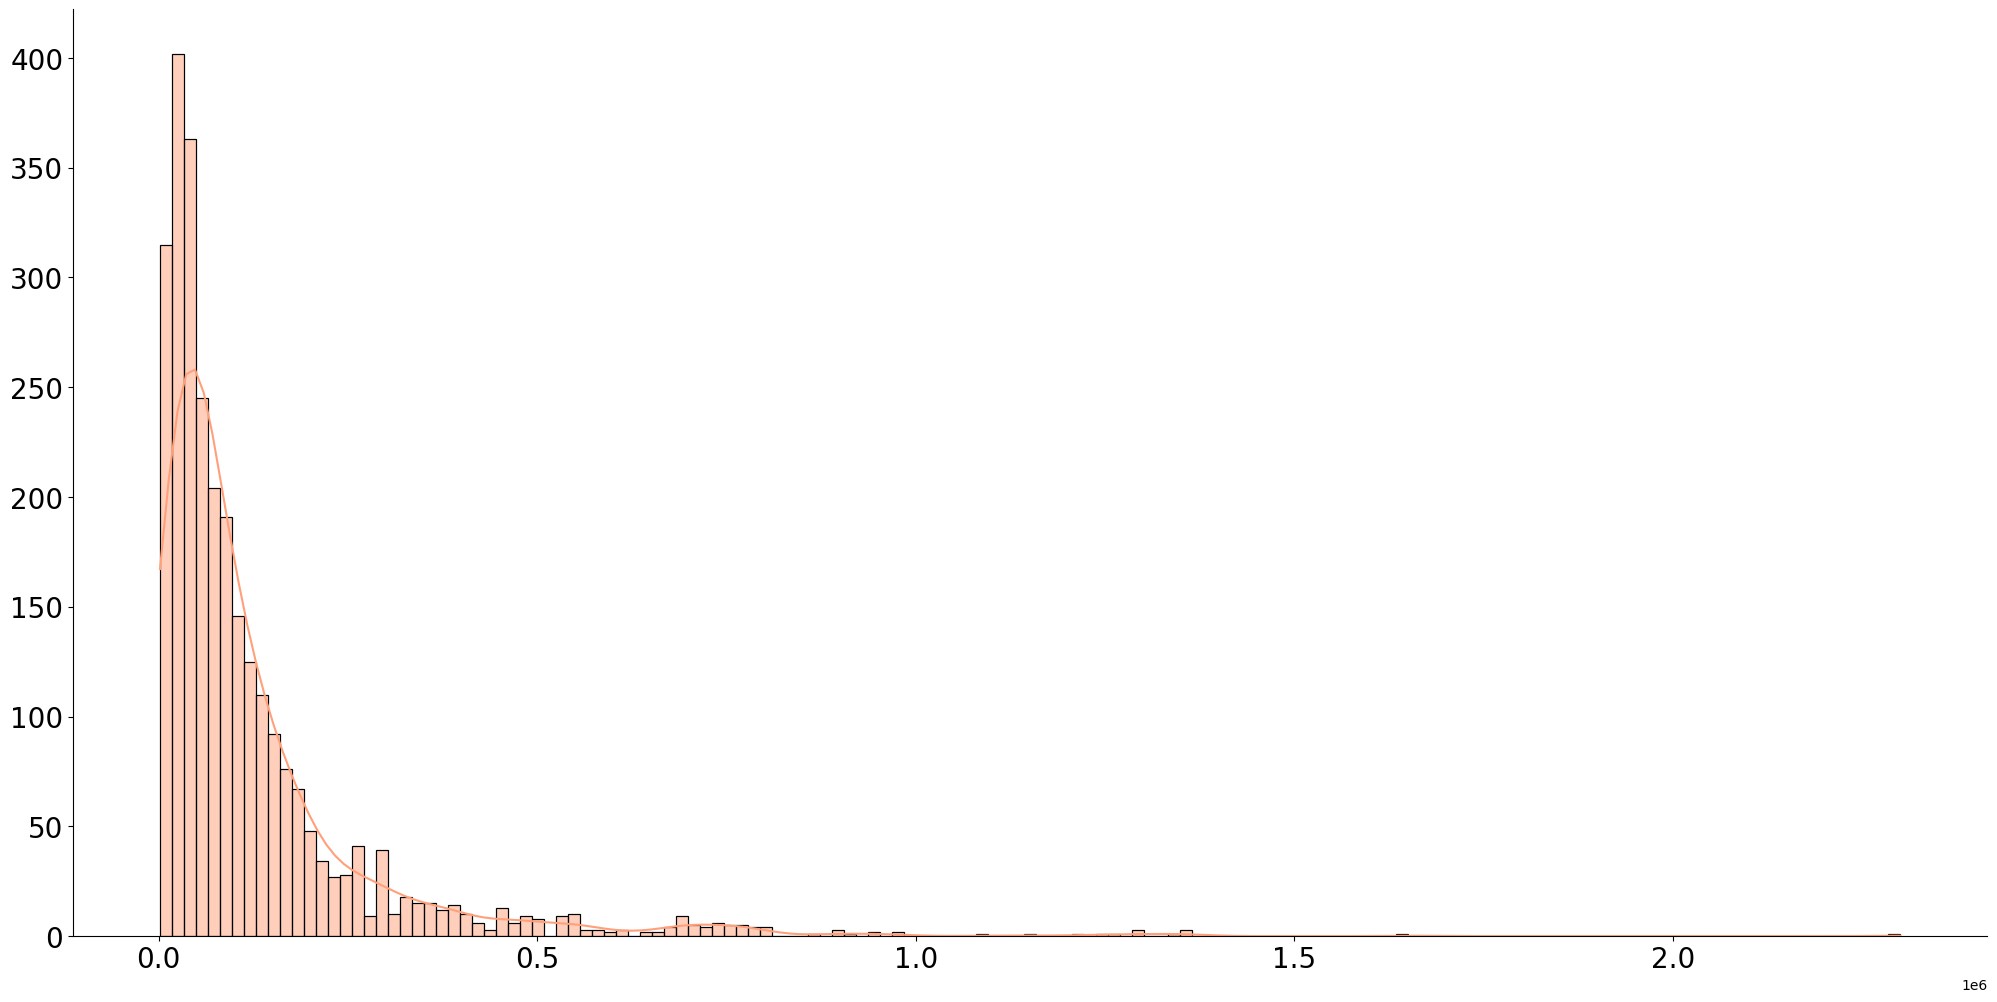

In [162]:
# Analysing all numerical variable (plus the Log(Traget variable)) distributions
sns.displot(data,x='Price',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [163]:
print(f"Fischer's kurtosis: {data['Price'].kurtosis()}\nskeweness: {data['Price'].skew()}\\nKolmogorov-Smirnov p-value: {sm.stats.diagnostic.kstest_normal(data['Price'],dist='norm',pvalmethod='approx')[1]}")

Fischer's kurtosis: 24.610637164787942
skeweness: 3.9571143529602346\nKolmogorov-Smirnov p-value: 0.0


In [164]:
data['Price'].describe()

count    2.804000e+03
mean     1.246002e+05
std      1.683114e+05
min      1.900000e+03
25%      3.290000e+04
50%      6.990000e+04
75%      1.449250e+05
max      2.300000e+06
Name: Price, dtype: float64

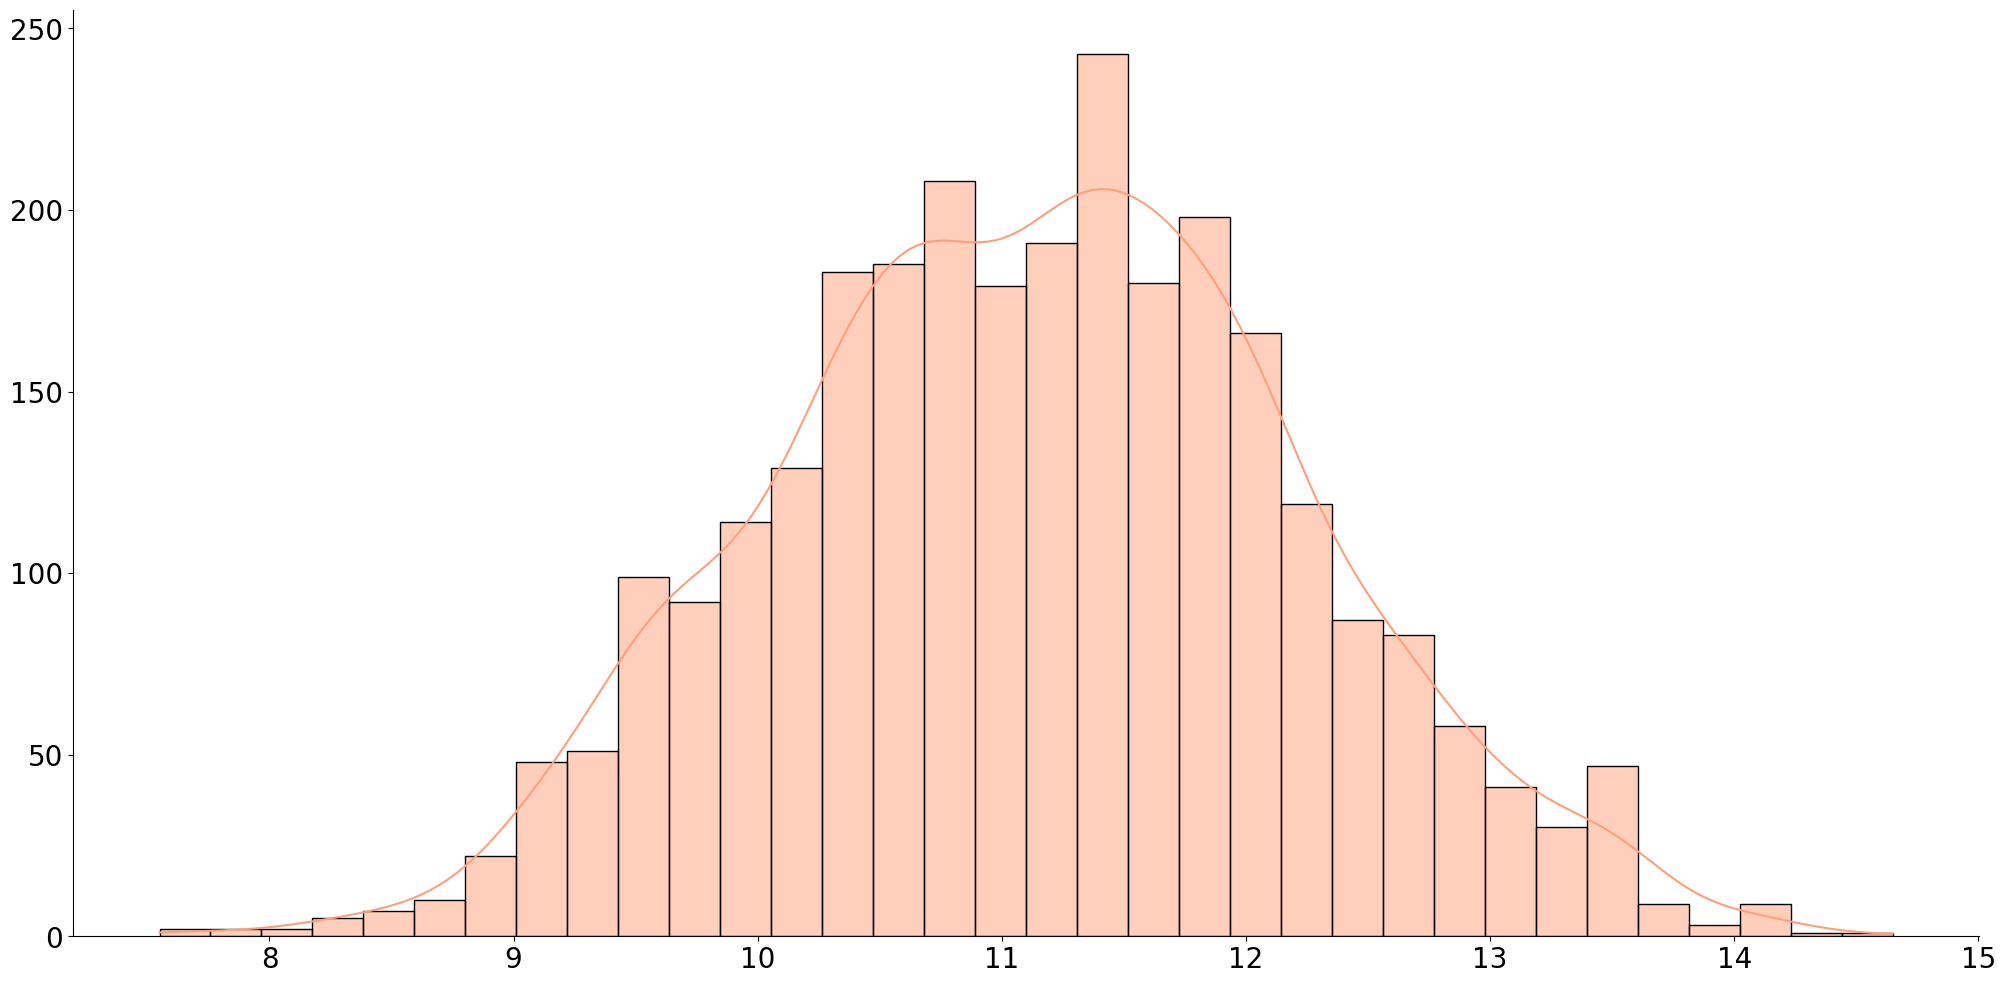

In [165]:
data['log_Price']=np.log(data['Price'])
sns.displot(data,x='log_Price',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [166]:
print(f"Fischer's kurtosis: {data['log_Price'].kurtosis()}\nskeweness: {data['log_Price'].skew()}\nKolmogorov-Smirnov p-value: {sm.stats.diagnostic.kstest_normal(data['log_Price'],dist='norm',pvalmethod='approx')[1]}")

Fischer's kurtosis: -0.1985110228795297
skeweness: 0.031157420601027774
Kolmogorov-Smirnov p-value: 0.08604277803195082


In [167]:
# I will use a log transformation of "Price" in the model.
data=data.drop('Price',axis=1)

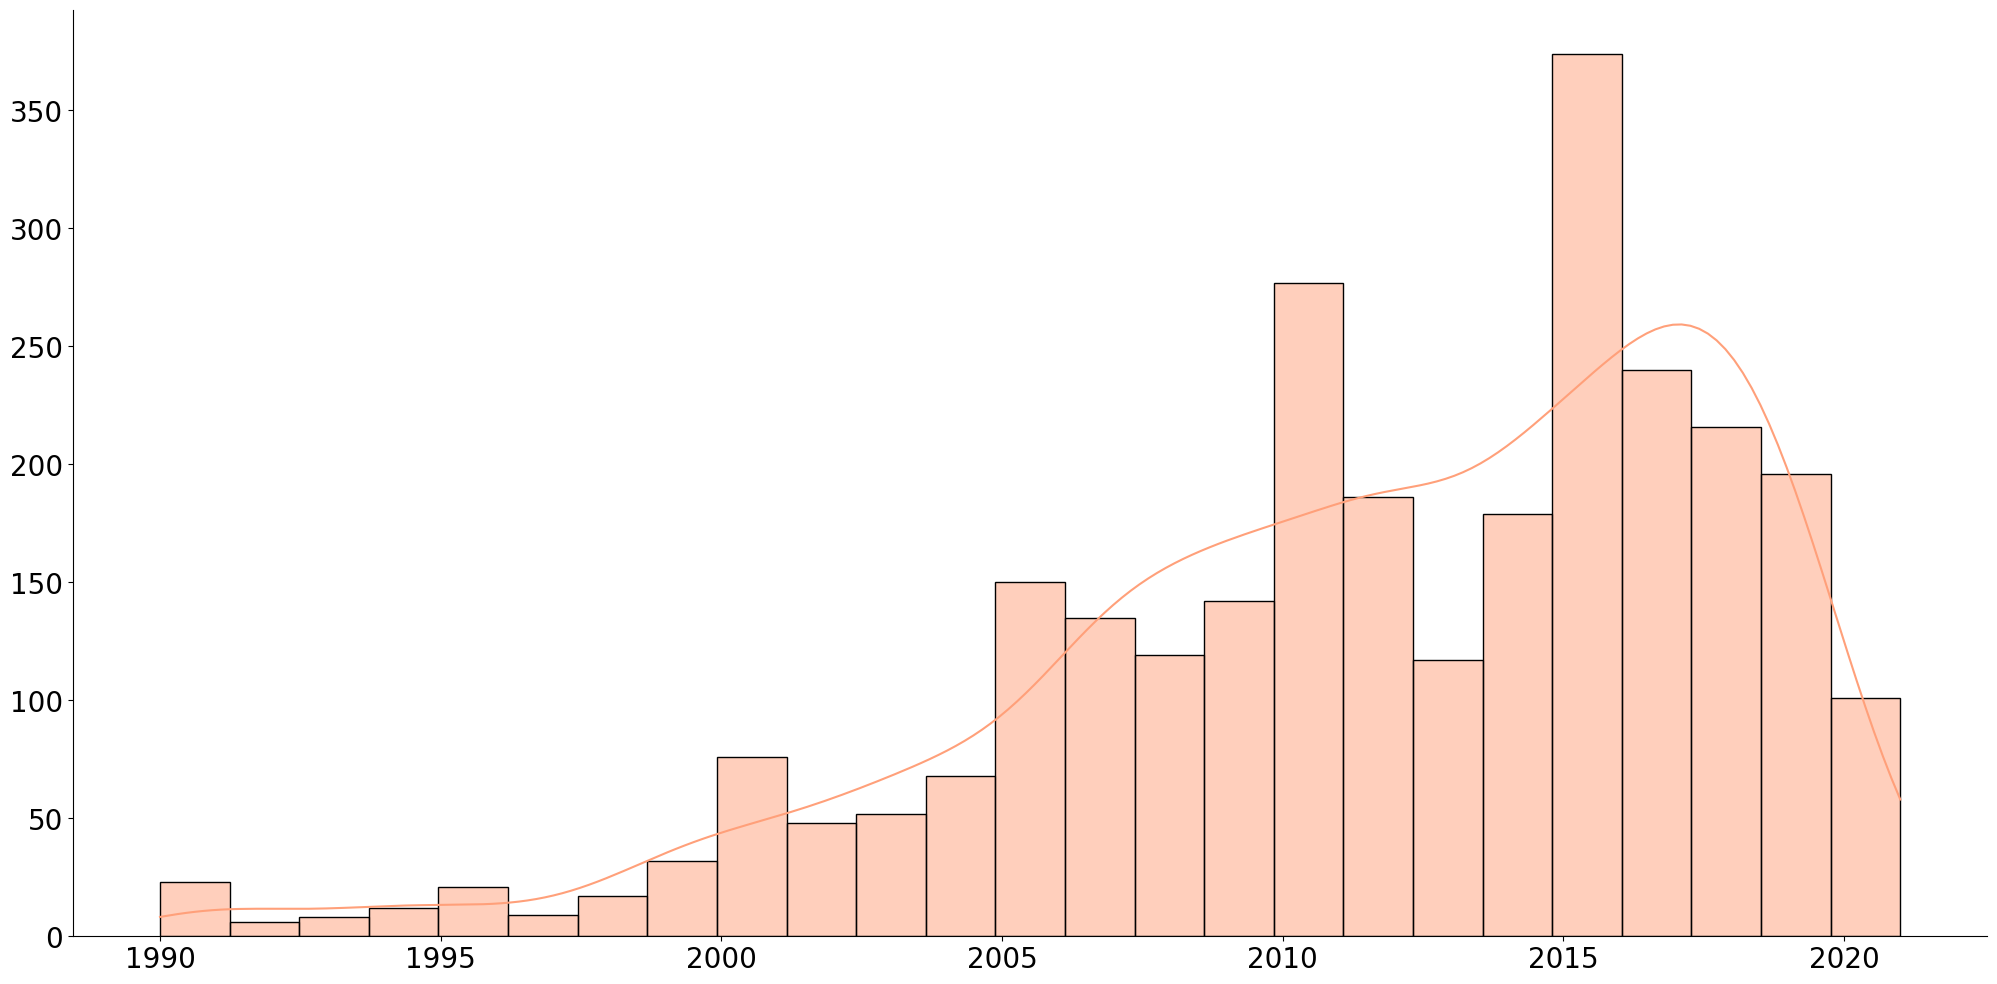

In [168]:
sns.displot(data,x='Production_year',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

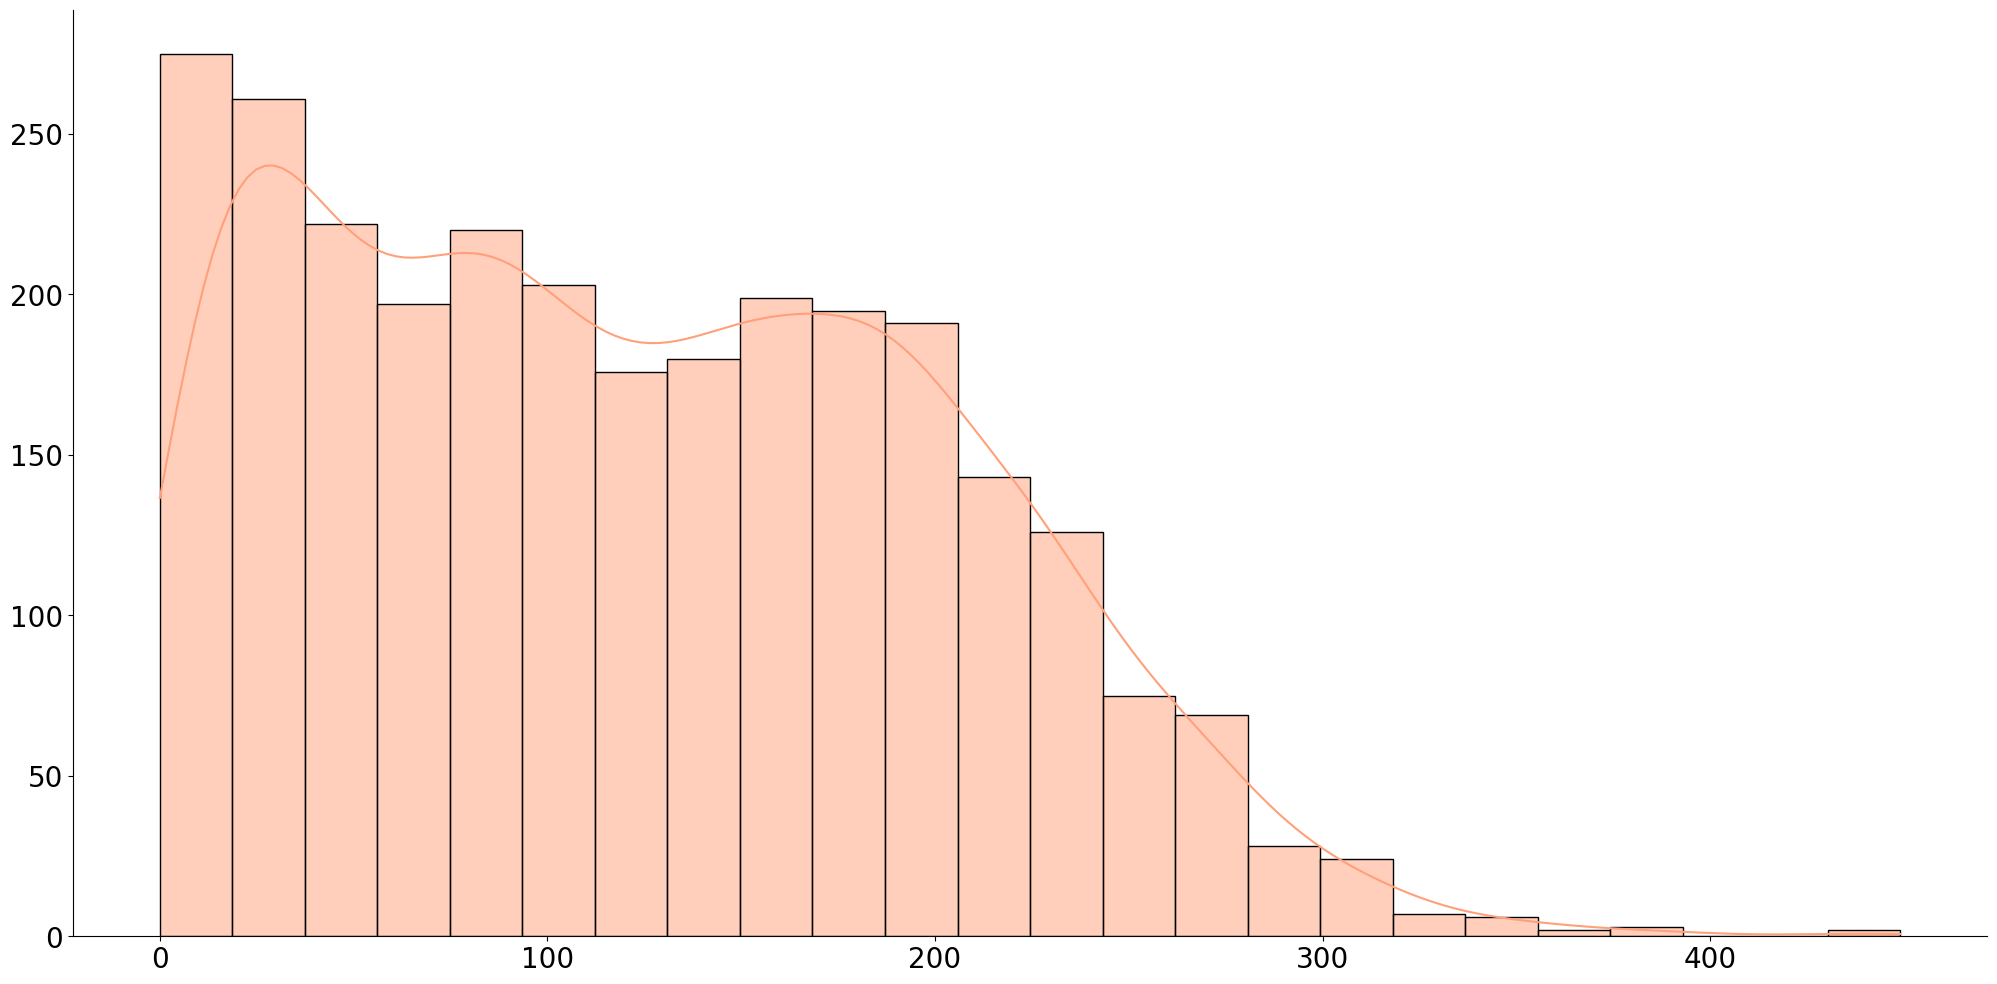

In [169]:
sns.displot(data,x='Mileage_kkm',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [170]:
print(f"Fischer's kurtosis: {data['Mileage_kkm'].kurtosis()}\nskeweness: {data['Mileage_kkm'].skew()}\nKolmogorov-Smirnov p-value: {sm.stats.diagnostic.kstest_normal(data['Mileage_kkm'],dist='norm',pvalmethod='approx')[1]}")

Fischer's kurtosis: -0.6194456206340382
skeweness: 0.38835137145223375
Kolmogorov-Smirnov p-value: 1.4654035856724286e-31


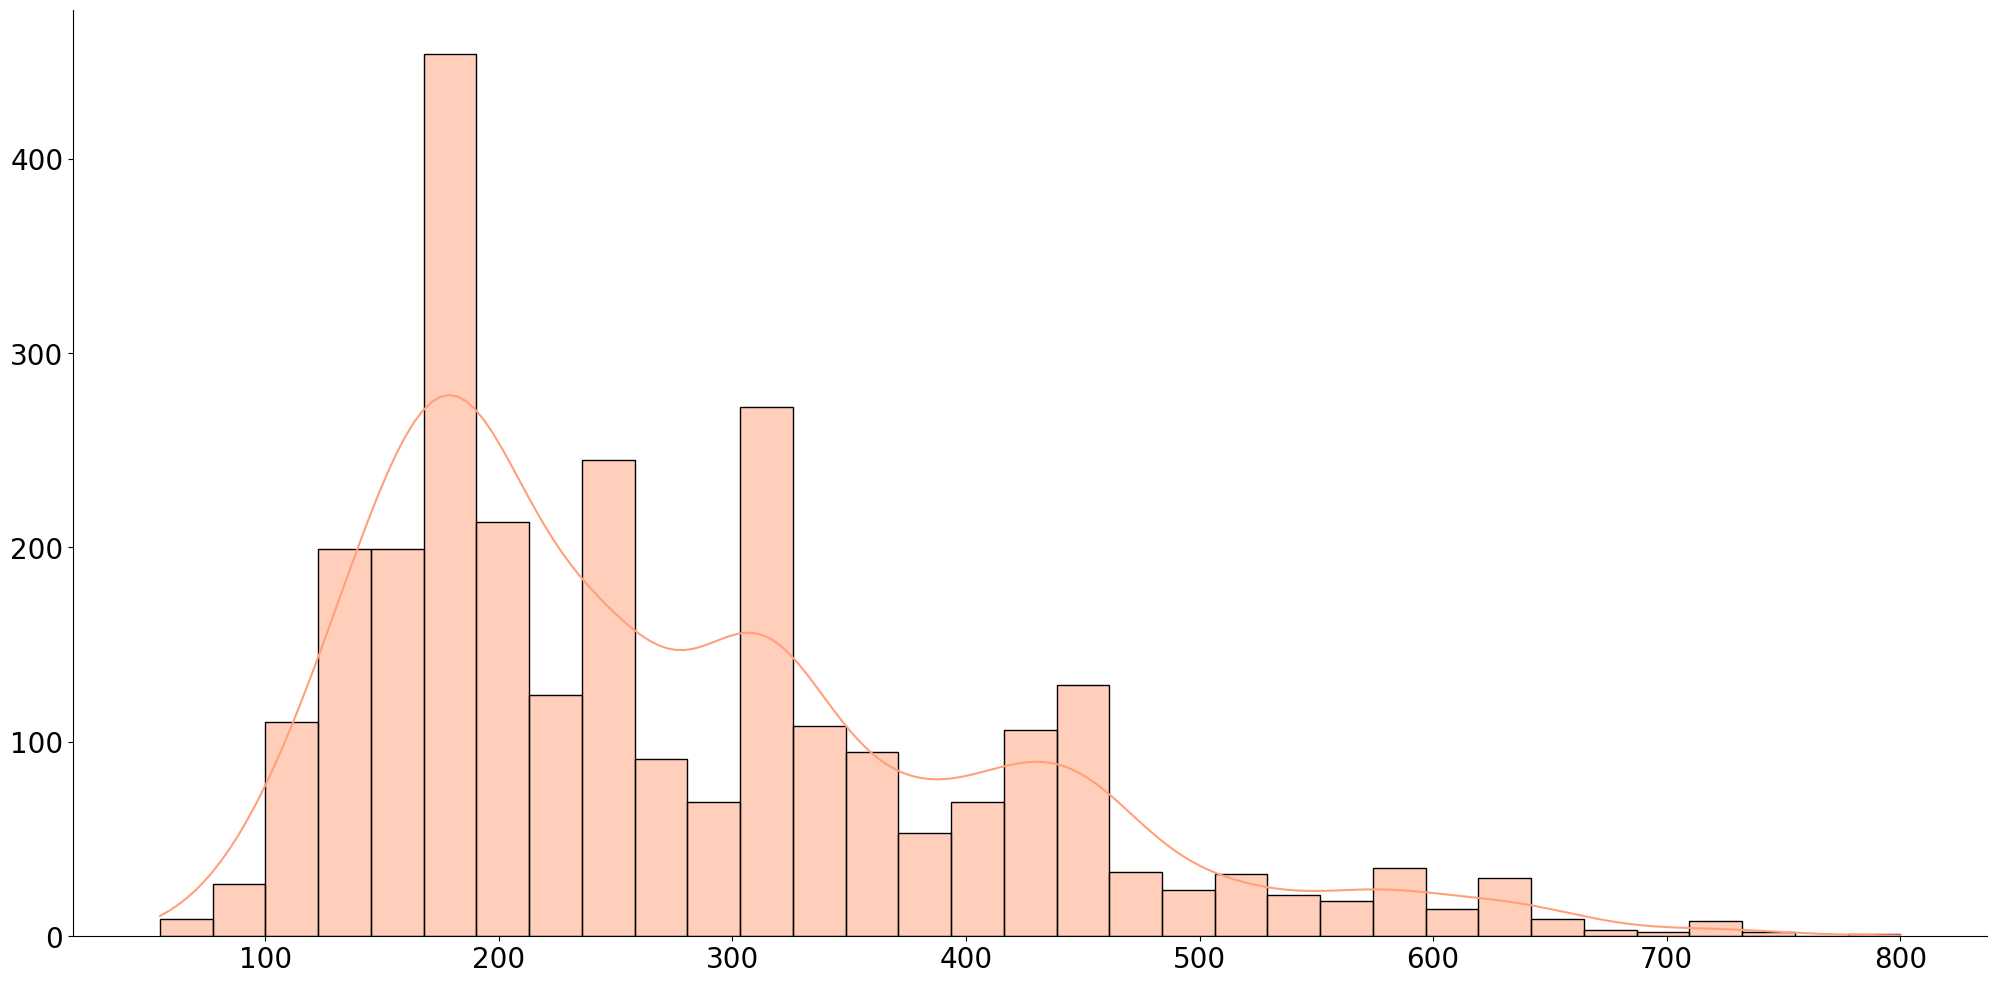

In [171]:
sns.displot(data,x='Power_HP',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [172]:
print(f"Fischer's kurtosis: {data['Power_HP'].kurtosis()}\nskeweness: {data['Power_HP'].skew()}\nKolmogorov-Smirnov p-value: {sm.stats.diagnostic.kstest_normal(data['Power_HP'],dist='norm',pvalmethod='approx')[1]}")

Fischer's kurtosis: 0.5357080717769347
skeweness: 0.9910656286713837
Kolmogorov-Smirnov p-value: 6.344222173335143e-113


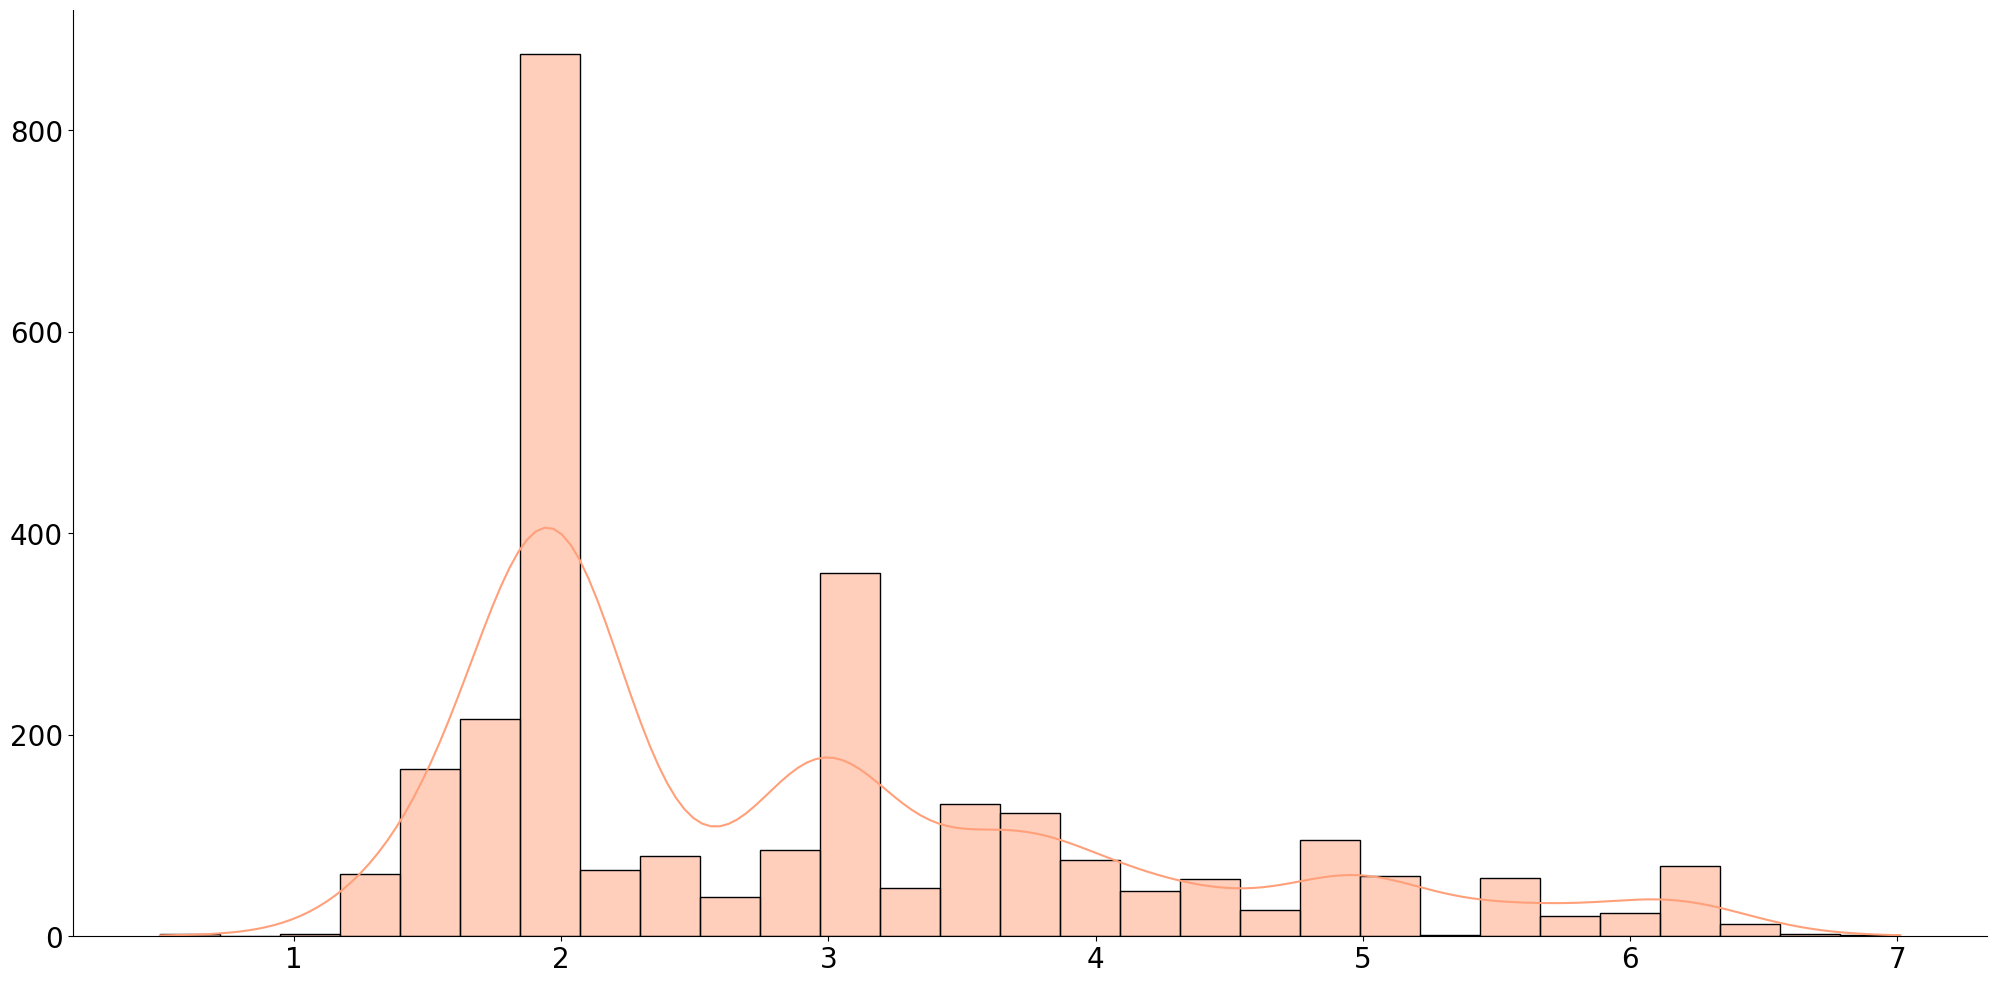

In [173]:
sns.displot(data,x='Displacement_dm3',color='lightsalmon',kde=True,height=10,aspect=2)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [174]:
print(f"Fischer's kurtosis: {data['Displacement_dm3'].kurtosis()}\nskeweness: {data['Mileage_kkm'].skew()}\nKolmogorov-Smirnov p-value: {sm.stats.diagnostic.kstest_normal(data['Displacement_dm3'],dist='norm',pvalmethod='approx')[1]}")

Fischer's kurtosis: 0.2439258245633371
skeweness: 0.38835137145223375
Kolmogorov-Smirnov p-value: 0.0


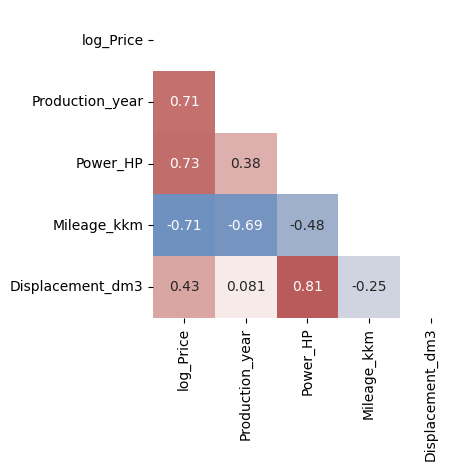

In [175]:
# Two worryingly high correlation coefficients are between: displacement and power, production year and mileage. 
# However, they are logical and naturally occuring.
fig,ax=plt.subplots(figsize=(4,4))
corr_df=data[['log_Price','Production_year','Power_HP','Mileage_kkm', 'Displacement_dm3']].corr(numeric_only=True)
sns.heatmap(corr_df,mask=np.triu(corr_df),cmap='vlag',annot=True,square=True,ax=ax,vmin=-1,vmax=1,cbar=False)
plt.show()

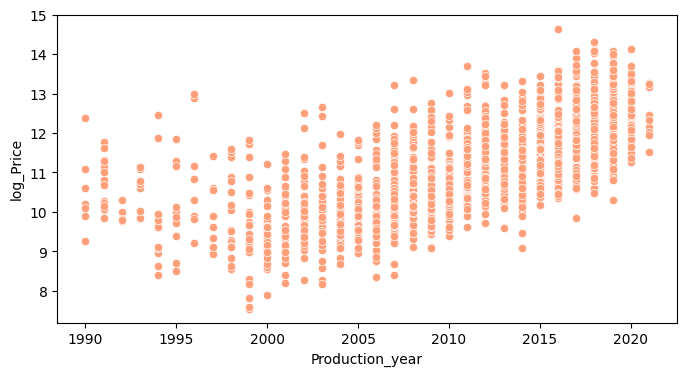

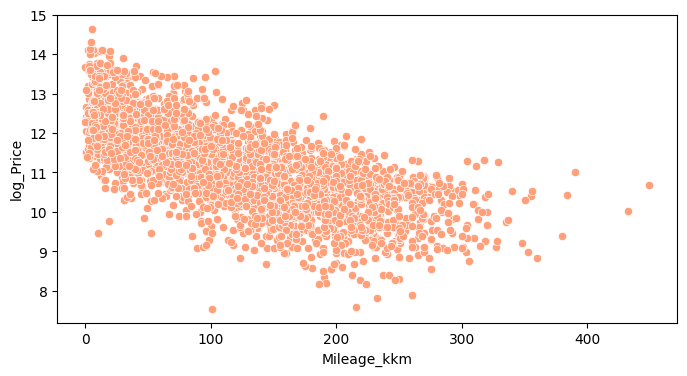

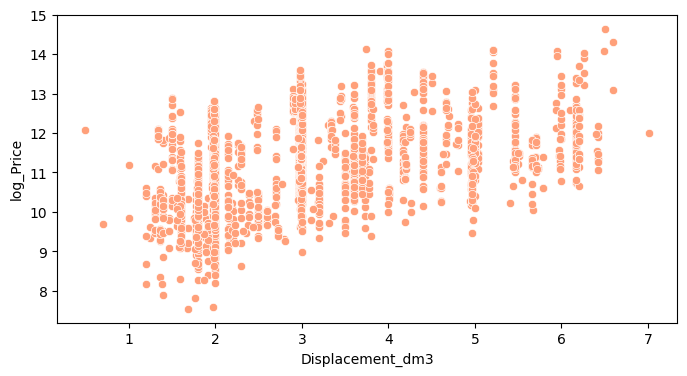

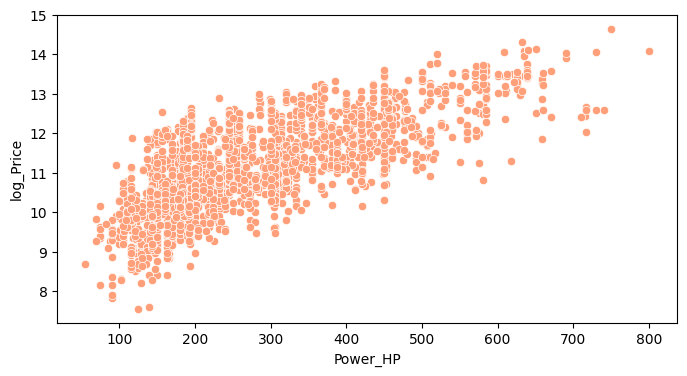

In [176]:
# Analysing the relationship between numerical variables and target variable
# It seems incorporating Power_HP^2 mnight be a good idea
for n in ['Production_year','Mileage_kkm','Displacement_dm3','Power_HP']:
    fig=plt.subplots(figsize=(8,4))
    sns.scatterplot(data,y='log_Price',x=n,color='lightsalmon')
    plt.show()

In [177]:
data=data.reset_index(drop=True)
data=data.drop(1538)
# Dropping 1538, because its values made no sense

In [178]:
# First, original model
F_coupe='log_Price~Production_year+Mileage_kkm+Power_HP+I(Power_HP**2)+I(Power_HP/Displacement_dm3)+Fuel_type+Colour+Vehicle_brand+Drive+Transmission+First_owner+Origin_country'
F='log_Price~Vehicle_brand+Production_year+Mileage_kkm+Power_HP+Fuel_type+Displacement_dm3+Drive+Transmission+Colour+First_owner+Origin_country'
result_mod=smf.ols(formula=F_coupe,data=data).fit()
print(reset_ramsey(result_mod,degree=2).pvalue)
result_mod.summary(alpha=0.05)

0.2253222042998929


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1174.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:45   Log-Likelihood:                -1681.2
No. Observations:                2803   AIC:                             3388.
Df Residuals:                    2790   BIC:                             3466.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -82.5728      4.059    -20.342      0.000     -90.532     -74.614
Production_year                    0.0457      0.002     22.615      0.000       0.042       0.050
Mileage_kkm                       -0.0031      0.000    -19.673      0.000      -0.003      -0.003
Power_HP                           0.0059      0.000     17.852      0.000       0.005       0.007
I(Power_HP ** 2)               -2.623e-06   4.44e-07     -5.907      0.000   -3.49e-06   -1.75e-06
I(Power_HP / Displacement_dm3)     0.0020      0.000      4.565      0.000       0.001       0.003
Fuel_type                          0.0092      0.045      0.203      0.839      -0.079       0.098
Colour                            -0.0173      0.018     -0.935      0.350      -0.054       0.019
Vehicle_brand                      0.2182      0.021     10.606      0.000       0.178       0.259
Drive                              0.1489      0.022      6.872      0.000       0.106       0.191
Transmission                       0.1579      0.023      7.008      0.000       0.114       0.202
First_owner                        0.2049      0.020     10.295      0.000       0.166       0.244
Origin_country                     0.2685      0.022     12.364      0.000       0.226       0.311
==============================================================================
Omnibus:                      207.196   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1055.235
Skew:                           0.101   Prob(JB):                    7.22e-230
Kurtosis:                       5.999   Cond. No.                     6.25e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.25e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [179]:
# model without insignificant variables
F_coupe2='log_Price~Production_year+Mileage_kkm+Power_HP+I(Power_HP**2)+I(Power_HP/Displacement_dm3)+Vehicle_brand+Drive+Transmission+First_owner+Origin_country'
result_mod2=smf.ols(formula=F_coupe2,data=data).fit()
print(reset_ramsey(result_mod2,degree=2).pvalue)
result_mod2.summary(alpha=0.05)

0.26591991303176693


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1410.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:45   Log-Likelihood:                -1681.7
No. Observations:                2803   AIC:                             3385.
Df Residuals:                    2792   BIC:                             3451.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -82.4963      4.047    -20.383      0.000     -90.432     -74.560
Production_year                    0.0457      0.002     22.682      0.000       0.042       0.050
Mileage_kkm                       -0.0031      0.000    -19.854      0.000      -0.003      -0.003
Power_HP                           0.0059      0.000     17.913      0.000       0.005       0.007
I(Power_HP ** 2)               -2.637e-06   4.44e-07     -5.943      0.000   -3.51e-06   -1.77e-06
I(Power_HP / Displacement_dm3)     0.0020      0.000      4.546      0.000       0.001       0.003
Vehicle_brand                      0.2161      0.020     10.601      0.000       0.176       0.256
Drive                              0.1483      0.022      6.849      0.000       0.106       0.191
Transmission                       0.1583      0.023      7.033      0.000       0.114       0.202
First_owner                        0.2049      0.020     10.296      0.000       0.166       0.244
Origin_country                     0.2697      0.022     12.453      0.000       0.227       0.312
==============================================================================
Omnibus:                      207.065   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.436
Skew:                           0.105   Prob(JB):                    7.96e-229
Kurtosis:                       5.992   Cond. No.                     6.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [180]:
# Model with a heteroscedascity robust White's covariance matrix
F_coupe_robust='log_Price~Production_year+Mileage_kkm+Power_HP+I(Power_HP**2)+I(Power_HP/Displacement_dm3)+Vehicle_brand+Drive+Transmission+First_owner+Origin_country'
result_mod_robust=smf.ols(formula=F_coupe_robust,data=data).fit(cov_type='HAC',cov_kwds={'maxlags':7})
print(reset_ramsey(result_mod_robust,degree=2).pvalue)
result_mod_robust.summary(alpha=0.05)

0.26591991303176693


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     755.4
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:45   Log-Likelihood:                -1681.7
No. Observations:                2803   AIC:                             3385.
Df Residuals:                    2792   BIC:                             3451.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -82.4963      8.770     -9.407      0.000     -99.685     -65.307
Production_year                    0.0457      0.004     10.475      0.000       0.037       0.054
Mileage_kkm                       -0.0031      0.000    -13.710      0.000      -0.004      -0.003
Power_HP                           0.0059      0.001     11.311      0.000       0.005       0.007
I(Power_HP ** 2)               -2.637e-06   7.56e-07     -3.490      0.000   -4.12e-06   -1.16e-06
I(Power_HP / Displacement_dm3)     0.0020      0.001      3.677      0.000       0.001       0.003
Vehicle_brand                      0.2161      0.034      6.338      0.000       0.149       0.283
Drive                              0.1483      0.028      5.373      0.000       0.094       0.202
Transmission                       0.1583      0.027      5.946      0.000       0.106       0.210
First_owner                        0.2049      0.020     10.344      0.000       0.166       0.244
Origin_country                     0.2697      0.026     10.387      0.000       0.219       0.321
==============================================================================
Omnibus:                      207.065   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.436
Skew:                           0.105   Prob(JB):                    7.96e-229
Kurtosis:                       5.992   Cond. No.                     6.23e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
[2] The condition number is large, 6.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
# Model with an autocorrelation and heteroscedascity robust Newey-West covariance matrix
F_coupe_robust='log_Price~Production_year+Mileage_kkm+Power_HP+I(Power_HP**2)+I(Power_HP/Displacement_dm3)+Vehicle_brand+Drive+Transmission+First_owner+Origin_country'
result_mod_robust2=smf.ols(formula=F_coupe_robust,data=data).fit(cov_type='HC0')
print(reset_ramsey(result_mod_robust2,degree=2).pvalue)
result_mod_robust2.summary(alpha=0.05)

0.26591991303176693


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_Price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     1352.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:45   Log-Likelihood:                -1681.7
No. Observations:                2803   AIC:                             3385.
Df Residuals:                    2792   BIC:                             3451.
Df Model:                          10                                         
Covariance Type:                  HC0                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -82.4963      6.985    -11.811      0.000     -96.186     -68.807
Production_year                    0.0457      0.003     13.168      0.000       0.039       0.052
Mileage_kkm                       -0.0031      0.000    -15.458      0.000      -0.004      -0.003
Power_HP                           0.0059      0.000     15.214      0.000       0.005       0.007
I(Power_HP ** 2)               -2.637e-06   5.39e-07     -4.893      0.000   -3.69e-06   -1.58e-06
I(Power_HP / Displacement_dm3)     0.0020      0.000      4.783      0.000       0.001       0.003
Vehicle_brand                      0.2161      0.021     10.087      0.000       0.174       0.258
Drive                              0.1483      0.022      6.894      0.000       0.106       0.190
Transmission                       0.1583      0.025      6.451      0.000       0.110       0.206
First_owner                        0.2049      0.019     10.519      0.000       0.167       0.243
Origin_country                     0.2697      0.023     11.815      0.000       0.225       0.314
==============================================================================
Omnibus:                      207.065   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1050.436
Skew:                           0.105   Prob(JB):                    7.96e-229
Kurtosis:                       5.992   Cond. No.                     6.23e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 6.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [182]:
w=smf.ols('result_mod2.resid.abs() ~ result_mod2.fittedvalues',data=data).fit().fittedvalues
# Weighted regression (weights dependent on the output value and residuals)
result_mod_weighted=smf.wls(formula=F_coupe2,data=data,weights=w).fit()
print(reset_ramsey(result_mod_weighted,degree=2).pvalue)
result_mod_weighted.summary()

0.16962922401362016


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              log_Price   R-squared:                       0.832
Model:                            WLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1383.
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:23:45   Log-Likelihood:                -1695.8
No. Observations:                2803   AIC:                             3414.
Df Residuals:                    2792   BIC:                             3479.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -82.0060      3.997    -20.516      0.000     -89.844     -74.168
Production_year                    0.0454      0.002     22.835      0.000       0.042       0.049
Mileage_kkm                       -0.0031      0.000    -19.945      0.000      -0.003      -0.003
Power_HP                           0.0061      0.000     18.045      0.000       0.005       0.007
I(Power_HP ** 2)               -2.815e-06   4.56e-07     -6.180      0.000   -3.71e-06   -1.92e-06
I(Power_HP / Displacement_dm3)     0.0020      0.000      4.432      0.000       0.001       0.003
Vehicle_brand                      0.2245      0.020     10.997      0.000       0.184       0.265
Drive                              0.1477      0.022      6.718      0.000       0.105       0.191
Transmission                       0.1543      0.022      6.889      0.000       0.110       0.198
First_owner                        0.2051      0.020     10.226      0.000       0.166       0.244
Origin_country                     0.2607      0.022     11.946      0.000       0.218       0.303
==============================================================================
Omnibus:                      220.857   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1179.417
Skew:                           0.128   Prob(JB):                    7.81e-257
Kurtosis:                       6.167   Cond. No.                     5.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.92e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

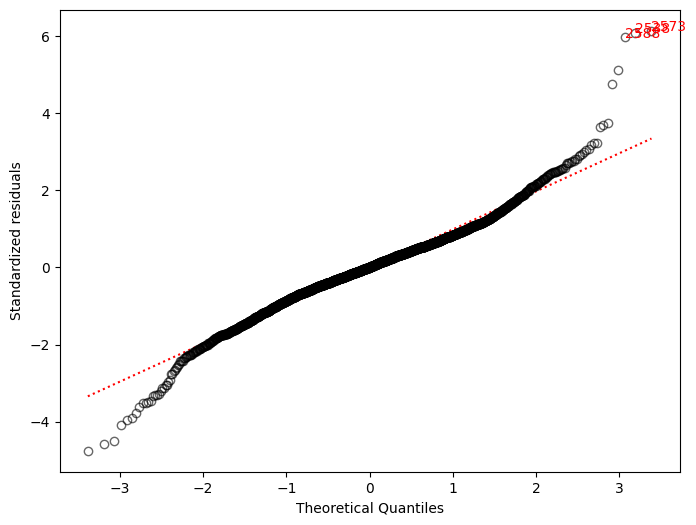

In [183]:
# Diagnostics of the second model (the robust and weighted models didn't differ much from this one)
# Slight outlier porblem. However there is nothing suspicious with these three data points in terms of their values.
plt.figure(figsize=(8,6))
lmdiag.q_q(result_mod2)
plt.title(None)
plt.show()

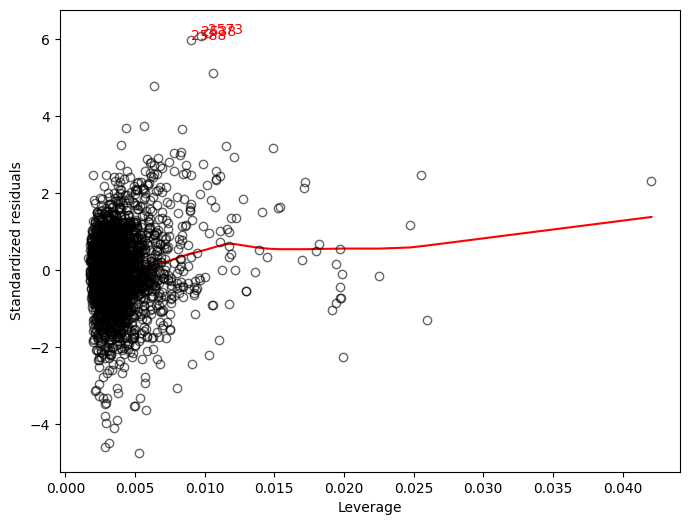

In [184]:
plt.figure(figsize=(8,6))
lmdiag.resid_lev(result_mod2)
plt.title(None)
plt.show()

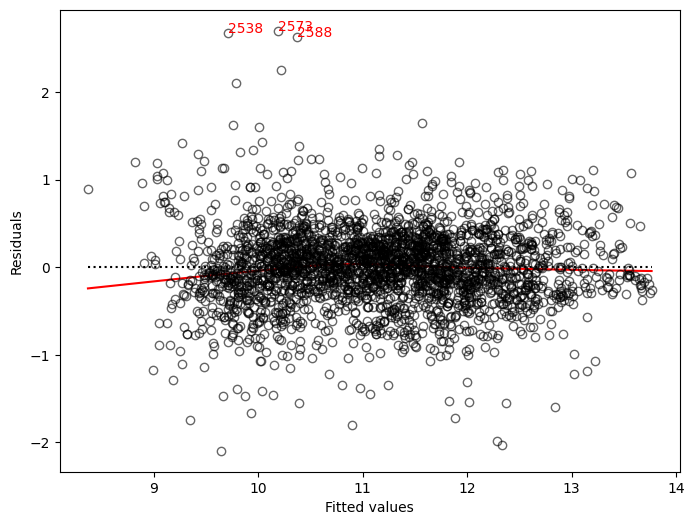

In [185]:
# Cannot say if homoscedascity is present
plt.figure(figsize=(8,6))
lmdiag.resid_fit(result_mod2)
plt.title(None)
plt.show()

In [186]:
round(sm.stats.jarque_bera(result_mod2.resid)[1],4)
# Residuals not distributed normally (p<0.05) - the "extra" condition isn't met

0.0

In [187]:
round(het_breuschpagan(result_mod2.resid, result_mod2.model.exog)[1],4)
# Heteroscedascity is present (p<0.05) - homescedacity condition of OLS isn't met
# No tests for autocorrelation needed - data points are assumed to be independent

0.0

In [188]:
vif=pd.DataFrame()
vif["VIF Factor"]=[variance_inflation_factor(result_mod2.model.exog, i) for i in range(result_mod2.model.exog.shape[1])]
vif["features"]=result_mod2.model.exog_names
vif[1:]
# Variance inflation is OK (power_hp and Power_HP**2 are not independent and other values don't look suspicious)

,VIF Factor,features
1,2.250850,Production_year
2,2.352880,Mileage_kkm
3,25.973730,Power_HP
4,22.705357,I(Power_HP ** 2)
5,1.768115,I(Power_HP / Displacement_dm3)
6,1.414307,Vehicle_brand
7,1.332931,Drive
8,1.593634,Transmission
9,1.246755,First_owner
10,1.399375,Origin_country


In [189]:
# Creating a publication table
from stargazer.stargazer import Stargazer
stargazer=Stargazer([result_mod,result_mod2,result_mod_robust,result_mod_robust2,result_mod_weighted])
stargazer.custom_columns(['First','Final','HC0','HAC','Weighted'], [1, 1,1,1,1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(6)
stargazer.covariate_order(['Production_year','Mileage_kkm','Power_HP','I(Power_HP ** 2)','I(Power_HP / Displacement_dm3)','Fuel_type','Transmission','Drive','Colour','Vehicle_brand','First_owner','Origin_country'])
stargazer.cov_spacing=3
stargazer.render_html()

'<table style="text-align:center"><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="5"><em>Dependent variable:log_Price</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">First</td><td colspan="1">Final</td><td colspan="1">HC0</td><td colspan="1">HAC</td><td colspan="1">Weighted</td></tr><tr><td colspan="6" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Production_year</td><td>0.045731<sup>***</sup></td><td>0.045692<sup>***</sup></td><td>0.045692<sup>***</sup></td><td>0.045692<sup>***</sup></td><td>0.045440<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002022)</td><td>(0.002014)</td><td>(0.004362)</td><td>(0.003470)</td><td>(0.001990)</td></tr><tr><td style="text-align:left">Mileage_kkm</td><td>-0.003126<sup>***</sup></td><td>-0.003138<sup>***</sup></td><td>-0.003138<sup>***</sup></td><td>-0.003138<sup>***</sup></td><td>-0.003134<sup>*